# Low-Rank JHU Logo Matrix Sensing: Convex (Nuclear Norm) vs Nonconvex (Burer–Monteiro)

This notebook implements the full experiment described in your design:
- Build a **strict rank-$r$ ground truth** $X^*$ from a JHU logo image by SVD truncation.
- Generate **Gaussian ensemble** linear measurements $y=\mathcal{A}(X^*)$.
- Compare:
  1. **Convex** nuclear-norm minimization: $\min_X \|X\|_*\;\text{s.t.}\;\mathcal{A}(X)=y$.
  2. **Nonconvex** factorized optimization: $\min_{U,V}\tfrac12\|\mathcal{A}(UV^\top)-y\|_2^2$ with **spectral init**.
- Produce the 3 plots: **phase transition**, **scalability/time**, **convergence trajectory**.

> Notes:
> - Convex SDP/nuclear norm solving becomes very slow as $n_1 n_2$ grows; we therefore restrict convex experiments to moderate sizes.
> - The measurement operator is implemented as $A_i \sim \mathcal{N}(0,1/m)$ sensing matrices with $y_i=\langle A_i,X\rangle$.


In [1]:

# =============== 0) Setup ===============
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap

from PIL import Image

# Convex solver
import cvxpy as cp

# Reproducibility
rng = np.random.default_rng(0)

# Path to the downloaded JHU logo (already placed next to this notebook in the sandbox)
LOGO_PATH = "jhulogo.jpeg"


## 1) Construct the strict rank-$r$ ground-truth matrix $X^*$
Steps:
1. Load the JHU logo image.
2. Convert to grayscale and resize to $n_1\times n_2$.
3. Compute SVD $M=U\Sigma V^\top$.
4. Truncate to rank $r$ to get $X^* = U_r\Sigma_rV_r^\top$.


<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
/var/folders/z1/3trj24q16t38dc4639_txlxr0000gn/T/ipykernel_38571/972652439.py:2: SyntaxWarning: invalid escape sequence '\i'
  """


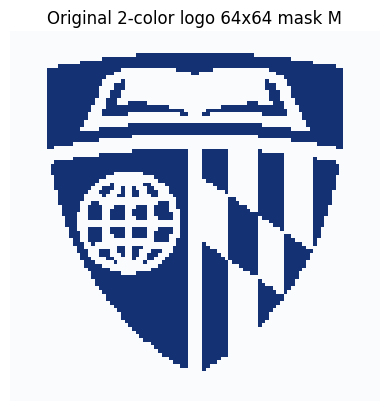

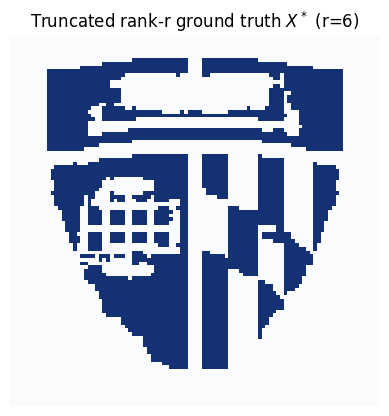

Top 15 singular values of X*: [40.193652 21.874378 13.335811 11.85441   9.623909  8.265529  0.
  0.        0.        0.        0.        0.        0.        0.
  0.      ]
Numerical rank of X* (tol=1e-10): 6


In [ ]:
def load_logo_matrix(path: str, n1: int, n2: int, invert: bool = False) -> np.ndarray:
    """
    Load a 2-color logo *without turning it into grayscale*.

    Returns:
        M \in [0,1]^{n1 x n2}: a binary-like mask matrix (background=0, foreground=1).
    Side effects:
        Sets global LOGO_BG_RGB, LOGO_FG_RGB for consistent color rendering.
    """
    global LOGO_BG_RGB, LOGO_FG_RGB

    img = Image.open(path).convert("RGB")
    img = img.resize((n2, n1), Image.Resampling.NEAREST)  # keep hard edges for 2-color logo
    arr = np.asarray(img, dtype=np.uint8)
    pix = arr.reshape(-1, 3)

    # If already exactly 2 (or fewer) unique colors, use them directly.
    uniq = np.unique(pix, axis=0)
    if uniq.shape[0] <= 2:
        colors = uniq
        # If only 1 color, create a dummy second color (shouldn't happen for logo)
        if colors.shape[0] == 1:
            colors = np.vstack([colors, colors])
        # background = more frequent color
        counts = [(pix == c).all(axis=1).sum() for c in colors]
        bg = colors[int(np.argmax(counts))]
        fg = colors[int(np.argmin(counts))]
        # Assign mask
        mask = (pix == fg).all(axis=1).astype(np.float64).reshape(n1, n2)
    else:
        # Robustly find 2 dominant colors via a tiny k-means (k=2).
        # (Avoid sklearn dependency.)
        rng_local = np.random.default_rng(0)
        sample_idx = rng_local.choice(pix.shape[0], size=min(5000, pix.shape[0]), replace=False)
        X = pix[sample_idx].astype(np.float64)

        # init centers: pick two far-ish points
        c0 = X[rng_local.integers(0, X.shape[0])]
        d = np.sum((X - c0)**2, axis=1)
        c1 = X[np.argmax(d)]
        C = np.stack([c0, c1], axis=0)

        for _ in range(15):
            dist0 = np.sum((X - C[0])**2, axis=1)
            dist1 = np.sum((X - C[1])**2, axis=1)
            lab = (dist1 < dist0).astype(np.int64)
            if (lab == 0).any():
                C[0] = X[lab == 0].mean(axis=0)
            if (lab == 1).any():
                C[1] = X[lab == 1].mean(axis=0)

        # Assign all pixels to nearest center
        P = pix.astype(np.float64)
        dist0 = np.sum((P - C[0])**2, axis=1)
        dist1 = np.sum((P - C[1])**2, axis=1)
        lab_full = (dist1 < dist0).astype(np.int64)

        # background = majority label
        cnt0 = np.sum(lab_full == 0)
        cnt1 = np.sum(lab_full == 1)
        bg_lab = 0 if cnt0 >= cnt1 else 1
        fg_lab = 1 - bg_lab

        bg = C[bg_lab]
        fg = C[fg_lab]
        mask = (lab_full == fg_lab).astype(np.float64).reshape(n1, n2)

    if invert:
        mask = 1.0 - mask
        bg, fg = fg, bg

    LOGO_BG_RGB = (bg / 255.0).clip(0, 1)
    LOGO_FG_RGB = (fg / 255.0).clip(0, 1)
    return mask


def svd_truncate(M: np.ndarray, r: int) -> np.ndarray:
    U, s, Vt = np.linalg.svd(M, full_matrices=False)
    s_trunc = np.zeros_like(s)
    s_trunc[:r] = s[:r]
    return U @ np.diag(s_trunc) @ Vt


def _to_mask01(X: np.ndarray, thresh: float = 0.5) -> np.ndarray:
    """Normalize to [0,1] then threshold -> {0,1} mask (for 2-color rendering)."""
    Xn = X.astype(np.float64)
    Xn = (Xn - Xn.min()) / (Xn.max() - Xn.min() + 1e-12)
    return (Xn >= thresh).astype(np.float64)


def logo_rgb_from_matrix(X: np.ndarray, thresh: float = 0.5) -> np.ndarray:
    """Map matrix -> RGB image using the two logo colors (no grayscale)."""
    global LOGO_BG_RGB, LOGO_FG_RGB
    mask = _to_mask01(X, thresh=thresh)
    bg = np.array(LOGO_BG_RGB)[None, None, :]
    fg = np.array(LOGO_FG_RGB)[None, None, :]
    return bg * (1.0 - mask[..., None]) + fg * mask[..., None]


def save_logo_figure(X: np.ndarray, title: str, outpath: str, thresh: float = 0.5):
    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    rgb = logo_rgb_from_matrix(X, thresh=thresh)
    plt.figure()
    plt.title(title)
    plt.imshow(rgb)
    plt.axis("off")
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close()


# --- Build a strict low-rank ground truth X* from a 2-color logo ---
n1, n2 = 100, 100
r = 6

M = load_logo_matrix(LOGO_PATH, n1=n1, n2=n2, invert=False)
X_star = svd_truncate(M, r=r)

# Visual sanity check (keep logo colors)
save_logo_figure(M, "Original 2-color logo mask M", "fig/00_logo_mask_M.png", thresh=0.5)
save_logo_figure(X_star, f"Truncated rank-r ground truth $X^*$ (r={r})", "fig/01_logo_ground_truth_Xstar.png", thresh=0.5)

plt.figure()
plt.title("Original 2-color logo 100x100 mask M")
plt.imshow(logo_rgb_from_matrix(M, thresh=0.5))
plt.axis("off")
plt.show()

plt.figure()
plt.title(f"Truncated rank-r ground truth $X^*$ (r={r})")
plt.imshow(logo_rgb_from_matrix(X_star, thresh=0.5))
plt.axis("off")
plt.show()

# Verify exact rank numerically
s = np.linalg.svd(X_star, compute_uv=False)
print("Top 15 singular values of X*:", np.round(s[:15], 6))
print("Numerical rank of X* (tol=1e-10):", np.sum(s > 1e-10))


## 2) Gaussian ensemble measurement operator
We sample sensing matrices $A_i\in\mathbb{R}^{n_1\times n_2}$ i.i.d. standard Gaussian.
Define
$$y_i = \langle A_i, X^*\rangle = \sum_{j,k} (A_i)_{jk}(X^*)_{jk}.$$
This yields $y\in\mathbb{R}^m$.


In [3]:

def make_gaussian_operator(n1: int, n2: int, m: int, rng: np.random.Generator):
    # A has shape (m, n1, n2)
    #A = rng.standard_normal(size=(m, n1, n2))
    # A: shape (m, n1, n2), Gaussian ensemble
    A = np.random.randn(m, n1, n2) / np.sqrt(m)

    return A

def A_forward(A: np.ndarray, X: np.ndarray) -> np.ndarray:
    # y_i = <A_i, X>
    return np.tensordot(A, X, axes=([1,2],[0,1]))  # (m,)

def A_adjoint(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    # A^*(y) = sum_i y_i A_i
    return np.tensordot(y, A, axes=([0],[0]))  # (n1,n2)

def fro_rel_err(X_hat: np.ndarray, X_star: np.ndarray) -> float:
    return np.linalg.norm(X_hat - X_star, 'fro') / (np.linalg.norm(X_star, 'fro') + 1e-12)


## 3) Method A: Convex nuclear norm minimization
Solve
$$\min_X \|X\|_*\quad\text{s.t. }\mathcal{A}(X)=y.$$
Implementation uses **CVXPY** with the nuclear norm atom `cp.normNuc(X)`.


In [4]:

def solve_convex_nuclear_norm(A: np.ndarray, y: np.ndarray, solver: str = "SCS", verbose: bool = False):
    m, n1, n2 = A.shape
    X = cp.Variable((n1, n2))

    # Linear constraints: <A_i, X> = y_i
    constraints = []
    for i in range(m):
        constraints.append(cp.sum(cp.multiply(A[i], X)) == y[i])

    obj = cp.Minimize(cp.normNuc(X))
    prob = cp.Problem(obj, constraints)

    t0 = time.time()
    prob.solve(solver=solver, verbose=verbose)
    t1 = time.time()

    if X.value is None:
        raise RuntimeError("Convex solver failed to return a solution. Try a different solver or smaller n/m.")
    return np.array(X.value), (t1 - t0), prob.status


## 4) Method B: Nonconvex factorized optimization (Burer–Monteiro)
Solve
$$\min_{U\in\mathbb{R}^{n_1\times r},\,V\in\mathbb{R}^{n_2\times r}} \;\frac12\|\mathcal{A}(UV^\top)-y\|_2^2.$$

### Spectral initialization
Compute $\tilde X = \mathcal{A}^*(y)$ and take its top-$r$ SVD: $\tilde X \approx U_0\Sigma_0V_0^\top$.
Set initial factors $U=U_0\Sigma_0^{1/2}$, $V=V_0\Sigma_0^{1/2}$.


In [5]:

def spectral_init(A, y, r):
    X0 = A_adjoint(A, y)          # ≈ A^*(y)
    X0 = X0 / y.size              # 关键：除以 m
    U, s, Vt = np.linalg.svd(X0, full_matrices=False)
    U0 = U[:, :r]
    V0 = Vt[:r, :].T
    S0 = np.diag(np.sqrt(np.maximum(s[:r], 0.0)))
    return U0 @ S0, V0 @ S0


def nonconvex_gd(
    A: np.ndarray,
    y: np.ndarray,
    X_star: np.ndarray,
    r: int,
    steps: int = 2000,
    lr: float = 1e-2,
    tol: float = 1e-10,
    record_every: int = 10,
    init: str = "random",
    init_rng: np.random.Generator = None,
    mu: float = 0.0,
    clip: float = None,
    verbose: bool = False,
    return_hist: bool = False,
):
    """
    Factorized nonconvex GD for min_{U,V} 0.5||A(UV^T)-y||^2 with optional balancing regularizer.

    Args:
        init: "random" or "spectral"
        init_rng: rng used ONLY for random init; defaults to global rng.
        mu: coefficient for balancing regularizer (mu/4)||U^TU - V^TV||_F^2
        clip: if provided, clip gradient norm of (U,V) updates to this value
        return_hist: if True, return (Xhat, history) else return Xhat
    """
    m, n1, n2 = A.shape
    if init_rng is None:
        init_rng = rng

    if init == "spectral":
        U, V = spectral_init(A, y, r)
    elif init == "random":
        U = 0.1 * init_rng.standard_normal((n1, r))
        V = 0.1 * init_rng.standard_normal((n2, r))
    else:
        raise ValueError("init must be 'spectral' or 'random'.")

    history = {"iter": [], "loss": [], "relerr": [], "time": []}
    t0 = time.time()
    last_loss = None

    for k in range(steps):
        X = U @ V.T
        rvec = A_forward(A, X) - y
        loss = 0.5 * float(rvec @ rvec)

        # Gradient wrt X: A^*(r)
        G = A_adjoint(A, rvec)
        gradU = G @ V
        gradV = G.T @ U

        # Optional balancing regularizer: (mu/4)||U^TU - V^TV||_F^2
        if mu and mu > 0:
            UtU = U.T @ U
            VtV = V.T @ V
            B = UtU - VtV
            loss = loss + (mu / 4.0) * float(np.sum(B * B))
            gradU = gradU + (mu / 2.0) * (U @ B)
            gradV = gradV - (mu / 2.0) * (V @ B)

        # Optional gradient clipping
        if clip is not None:
            gnorm = np.sqrt(np.sum(gradU**2) + np.sum(gradV**2))
            if gnorm > clip:
                scale = clip / (gnorm + 1e-12)
                gradU *= scale
                gradV *= scale

        # GD step
        U_new = U - lr * gradU
        V_new = V - lr * gradV

        # stopping based on parameter change
        if np.linalg.norm(U_new - U) / (np.linalg.norm(U) + 1e-12) < tol and \
           np.linalg.norm(V_new - V) / (np.linalg.norm(V) + 1e-12) < tol:
            U, V = U_new, V_new
            if verbose:
                print(f"[noncvx] early stop at iter {k}")
            break

        U, V = U_new, V_new

        if (k % record_every) == 0 or (k == steps - 1):
            relerr = fro_rel_err(U @ V.T, X_star)
            history["iter"].append(k)
            history["loss"].append(loss)
            history["relerr"].append(relerr)
            history["time"].append(time.time() - t0)

            if verbose and last_loss is not None and (k % (record_every*10) == 0):
                print(f"[noncvx] iter={k}, loss={loss:.3e}, relerr={relerr:.3e}")
            last_loss = loss

    Xhat = U @ V.T
    if return_hist:
        return Xhat, history
    return Xhat


## 5) Single-run sanity check (fixed $n_1,n_2,r,m$)
This cell runs both methods once and prints relative errors and runtimes.


Running convex nuclear norm minimization...
Convex status=optimal, time=337.57s, rel-Fro err=5.765e-05

Running nonconvex factorized GD 5 times with different random initializations...
  run 0: seed=100, rel-Fro err=8.408e-12
  run 1: seed=101, rel-Fro err=8.296e-12
  run 2: seed=102, rel-Fro err=3.332e-12


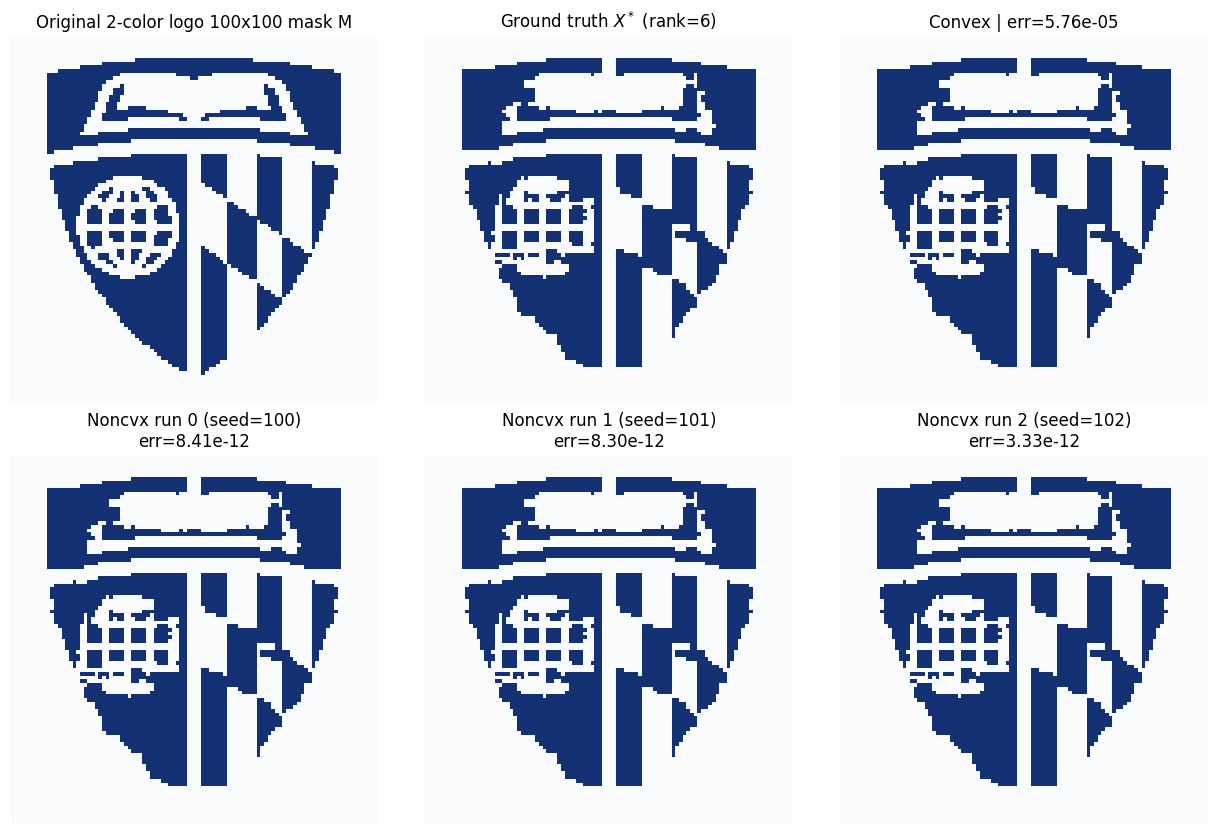

In [6]:
# =============== 4) Single-run sanity check (with colored logo + 5 random nonconvex inits) ===============

# Pick m around your suggested starting scale: m ≈ 2r(n1+n2)
m = int(2 * r * (n1 + n2))

A = make_gaussian_operator(n1, n2, m, rng)
y = A_forward(A, X_star)

os.makedirs("fig", exist_ok=True)

# ---- Convex ----
print("Running convex nuclear norm minimization...")
try:
    X_cvx, t_cvx, status = solve_convex_nuclear_norm(A, y, solver="SCS", verbose=False)
    err_cvx = fro_rel_err(X_cvx, X_star)
    print(f"Convex status={status}, time={t_cvx:.2f}s, rel-Fro err={err_cvx:.3e}")
except Exception as e:
    X_cvx, t_cvx, err_cvx = None, None, None
    print("Convex failed:", repr(e))

# ---- Nonconvex (run 3 different random inits) ----
print("\nRunning nonconvex factorized GD 5 times with different random initializations...")
noncvx_runs = []
base_seed = 100
for k in range(3):
    seed_k = base_seed + k
    rng_k = np.random.default_rng(seed_k)

    # We only change init; keep A,y fixed.
    X_nc_k, hist_k = nonconvex_gd(
        A, y, X_star, r=r,
        steps=2000,
        lr=1e-2,
        init="random",
        init_rng=rng_k,
        mu=1e-2,
        clip=1e3,
        verbose=False,
        return_hist=True
    )
    err_k = fro_rel_err(X_nc_k, X_star)
    noncvx_runs.append((k, seed_k, X_nc_k, err_k))
    print(f"  run {k}: seed={seed_k}, rel-Fro err={err_k:.3e}")

    # Save each nonconvex reconstruction as a colored logo image
    save_logo_figure(
        X_nc_k,
        title=f"Nonconvex recovery (run {k}, seed={seed_k}) | err={err_k:.2e}",
        outpath=f"fig/sanity_noncvx_run{k:02d}_seed{seed_k}.png",
        thresh=0.5
    )

# Save convex reconstruction too (if available)
if X_cvx is not None:
    save_logo_figure(
        X_cvx,
        title=f"Convex nuclear-norm recovery | err={err_cvx:.2e}",
        outpath="fig/sanity_convex_recovery.png",
        thresh=0.5
    )

# Save a combined panel: GT + Convex + 5 Nonconvex runs (all in color)
panels = 1 + (1 if X_cvx is not None else 0) + len(noncvx_runs)
cols = 3
rows = int(math.ceil(panels / cols))

plt.figure(figsize=(4.2 * cols, 4.2 * rows))

p = 1
ax = plt.subplot(rows, cols, p)
ax.set_title("Original 2-color logo 100x100 mask M")
ax.imshow(logo_rgb_from_matrix(M, thresh=0.5))
ax.axis("off")
p += 1

ax = plt.subplot(rows, cols, p)
ax.set_title(f"Ground truth $X^*$ (rank={r})")
ax.imshow(logo_rgb_from_matrix(X_star, thresh=0.5))
ax.axis("off")
p += 1

if X_cvx is not None:
    ax = plt.subplot(rows, cols, p)
    ax.set_title(f"Convex | err={err_cvx:.2e}")
    ax.imshow(logo_rgb_from_matrix(X_cvx, thresh=0.5))
    ax.axis("off")
    p += 1

for (k, seed_k, X_nc_k, err_k) in noncvx_runs:
    ax = plt.subplot(rows, cols, p)
    ax.set_title(f"Noncvx run {k} (seed={seed_k})\nerr={err_k:.2e}")
    ax.imshow(logo_rgb_from_matrix(X_nc_k, thresh=0.5))
    ax.axis("off")
    p += 1

plt.tight_layout()
plt.savefig("fig/sanity_panel_cvx_vs_3noncvx.png", dpi=200, bbox_inches="tight")
plt.show()


## 6) Experiment 1: Phase transition (recovery success vs. normalized measurements)
- X-axis: normalized measurement count $m / (r(n_1+n_2-r))$.
- Y-axis: success rate over repeated random trials.
- Success: relative Frobenius error $<10^{-3}$.

**Important**: convex runs are expensive; use small/medium sizes (e.g., 32×32 or 46×81).


mf=1.00  m=  295  succ(cvx)=0/10  succ(nc)=0/10
mf=1.50  m=  442  succ(cvx)=0/10  succ(nc)=0/10
mf=1.60  m=  472  succ(cvx)=2/10  succ(nc)=0/10
mf=1.70  m=  502  succ(cvx)=4/10  succ(nc)=8/10
mf=1.80  m=  531  succ(cvx)=10/10  succ(nc)=10/10
mf=2.00  m=  590  succ(cvx)=10/10  succ(nc)=10/10
mf=3.00  m=  885  succ(cvx)=10/10  succ(nc)=10/10


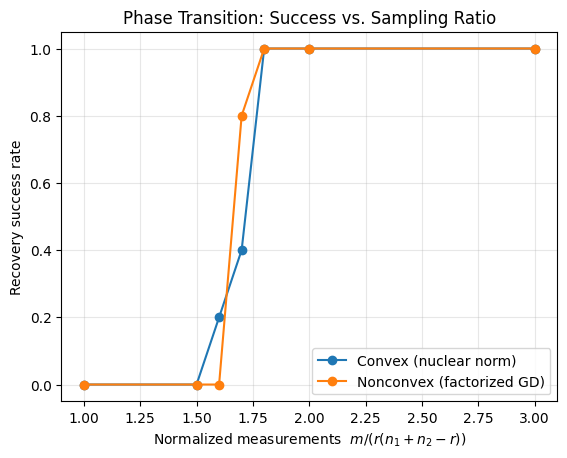

In [7]:

def phase_transition_experiment(
    X_star: np.ndarray, r: int,
    m_factors: list,
    trials: int = 10,
    err_thresh: float = 1e-3,
    convex_solver: str = "SCS",
    nonconvex_steps: int = 3000,
    nonconvex_lr: float = 1e-3,
):
    n1, n2 = X_star.shape
    denom = r * (n1 + n2 - r)
    results = []

    for mf in m_factors:
        m = int(round(mf * denom))
        m = max(m, 1)

        succ_cvx = 0
        succ_nc = 0
        times_cvx = []
        times_nc = []

        for t in range(trials):
            A = make_gaussian_operator(n1, n2, m, rng)
            y = A_forward(A, X_star)

            # Nonconvex
            t0 = time.time()
            X_nc = nonconvex_gd(A, y, X_star, r=r, steps=nonconvex_steps, lr=nonconvex_lr, record_every=50)
            t_nc = time.time() - t0
            e_nc = fro_rel_err(X_nc, X_star)
            succ_nc += int(e_nc < err_thresh)
            times_nc.append(t_nc)

            # Convex
            try:
                X_cvx, t_cvx, status = solve_convex_nuclear_norm(A, y, solver=convex_solver, verbose=False)
                e_cvx = fro_rel_err(X_cvx, X_star)
                succ_cvx += int(e_cvx < err_thresh)
                times_cvx.append(t_cvx)
            except Exception:
                # treat failure as not recovered
                times_cvx.append(np.nan)

        results.append({
            "m_factor": mf,
            "m": m,
            "succ_rate_convex": succ_cvx / trials,
            "succ_rate_nonconvex": succ_nc / trials,
            "time_convex_med": np.nanmedian(times_cvx),
            "time_nonconvex_med": np.median(times_nc),
        })
        print(f"mf={mf:.2f}  m={m:5d}  succ(cvx)={succ_cvx}/{trials}  succ(nc)={succ_nc}/{trials}")

    return results

# Recommended: use smaller logo for a feasible convex phase-transition run
n1_pt, n2_pt, r_pt = 32, 32, 5
M_pt = load_logo_matrix(LOGO_PATH, n1=n1_pt, n2=n2_pt, invert=False)
X_star_pt = svd_truncate(M_pt, r=r_pt)

m_factors = [1.0, 1.5, 1.6, 1.7, 1.8, 2.0, 3.0]  # normalized by r(n1+n2-r)
pt_results = phase_transition_experiment(
    X_star_pt, r=r_pt,
    m_factors=m_factors,
    trials=10,
    err_thresh=1e-3,
    convex_solver="SCS",
    nonconvex_steps=2000,
    nonconvex_lr=1e-2,
)

# Plot success rates
xs = [d["m_factor"] for d in pt_results]
yc = [d["succ_rate_convex"] for d in pt_results]
yn = [d["succ_rate_nonconvex"] for d in pt_results]

plt.figure()
plt.plot(xs, yc, marker="o", label="Convex (nuclear norm)")
plt.plot(xs, yn, marker="o", label="Nonconvex (factorized GD)")
plt.xlabel(r"Normalized measurements  $m / (r(n_1+n_2-r))$")
plt.ylabel("Recovery success rate")
plt.ylim([-0.05, 1.05])
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Phase Transition: Success vs. Sampling Ratio")
plt.show()


## 7) Experiment 2: Scalability (wall-clock time vs. matrix size)
Fix a measurement ratio **above** the phase transition region and compare runtime.

- X-axis: $n$ (we use square $n\times n$ resized logos).
- Y-axis: wall-clock time (log-scale).

We keep rank $r$ fixed and set $m = \lceil \alpha\, r(2n-r)\rceil$.

> Convex will likely become infeasible beyond $n\approx 60\sim 100$ depending on hardware/solver.


n=  20 m=   525  t_nc=   0.14s  t_cvx=0.4968748092651367
n=  30 m=   825  t_nc=   1.54s  t_cvx=2.770638942718506
n=  40 m=  1125  t_nc=   2.12s  t_cvx=7.990985870361328
n=  60 m=  1725  t_nc=   5.08s  t_cvx=39.551785945892334
n=  70 m=  2025  t_nc=   5.61s  t_cvx=77.70966506004333
n= 100 m=  2925  t_nc=   7.87s  t_cvx=306.5089750289917


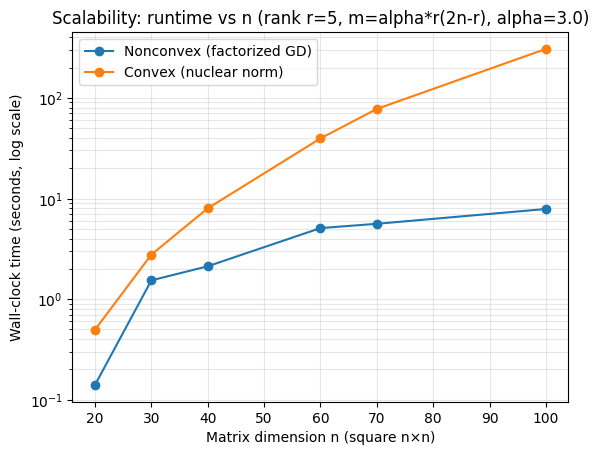

In [8]:

def scalability_experiment(
    sizes: list,
    r: int,
    alpha: float,
    nonconvex_steps: int = 1500,
    nonconvex_lr: float = 1e-2,
    convex_solver: str = "SCS",
):
    out = []
    for n in sizes:
        M = load_logo_matrix(LOGO_PATH, n1=n, n2=n, invert=False)
        X_star = svd_truncate(M, r=r)

        denom = r * (2*n - r)
        m = int(math.ceil(alpha * denom))

        A = make_gaussian_operator(n, n, m, rng)
        y = A_forward(A, X_star)

        # Nonconvex time
        t0 = time.time()
        _X_nc = nonconvex_gd(A, y, X_star, r=r, steps=nonconvex_steps, lr=nonconvex_lr, record_every=100)
        t_nc = time.time() - t0

        # Convex time (may fail)
        try:
            _X_cvx, t_cvx, status = solve_convex_nuclear_norm(A, y, solver=convex_solver, verbose=False)
        except Exception:
            t_cvx = np.nan

        out.append({"n": n, "m": m, "t_nonconvex": t_nc, "t_convex": t_cvx})
        print(f"n={n:4d} m={m:6d}  t_nc={t_nc:7.2f}s  t_cvx={t_cvx if np.isfinite(t_cvx) else 'NaN'}")
    return out

sizes = [20, 30, 40, 60, 70, 100]  # increase if your machine can handle convex beyond this
r_sc = 5
alpha = 3.0  # "above" transition, consistent with your expected ~3x threshold

sc_results = scalability_experiment(
    sizes=sizes, r=r_sc, alpha=alpha,
    nonconvex_steps=1500, nonconvex_lr=1e-2,
    convex_solver="SCS"
)

xs = [d["n"] for d in sc_results]
t_nc = [d["t_nonconvex"] for d in sc_results]
t_cvx = [d["t_convex"] for d in sc_results]

plt.figure()
plt.plot(xs, t_nc, marker="o", label="Nonconvex (factorized GD)")
plt.plot(xs, t_cvx, marker="o", label="Convex (nuclear norm)")
plt.yscale("log")
plt.xlabel("Matrix dimension n (square n×n)")
plt.ylabel("Wall-clock time (seconds, log scale)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.title(f"Scalability: runtime vs n (rank r={r_sc}, m=alpha*r(2n-r), alpha={alpha})")
plt.show()


## 8) Experiment 3: Convergence trajectory (error vs. iterations)
Fix $n,m$ in the recoverable regime and plot the **relative Frobenius error** over iterations for nonconvex GD.


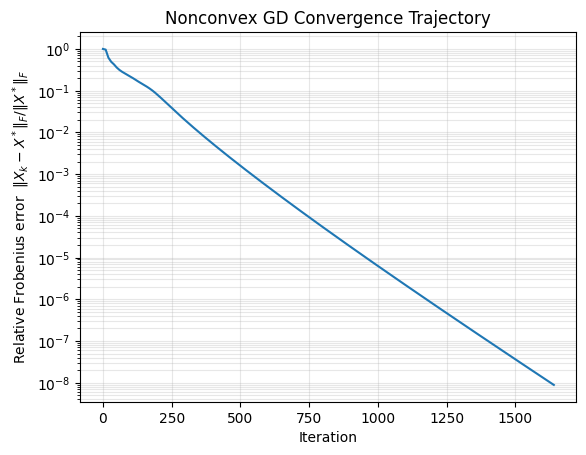

Final rel error: 8.847373821545188e-09


In [9]:
# Fix a medium-size instance
n_traj = 64
r_traj = 10
M_traj = load_logo_matrix(LOGO_PATH, n1=n_traj, n2=n_traj, invert=False)
X_star_traj = svd_truncate(M_traj, r=r_traj)

alpha_traj = 3.0
m_traj = int(math.ceil(alpha_traj * r_traj * (2*n_traj - r_traj)))

A = make_gaussian_operator(n_traj, n_traj, m_traj, rng)
y = A_forward(A, X_star_traj)

X_nc, hist = nonconvex_gd(
    A, y, X_star_traj, r=r_traj,
    steps=4000, lr=1e-2, record_every=10,
    init="spectral",
    return_hist=True
)

plt.figure()
plt.plot(hist["iter"], hist["relerr"])
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel(r"Relative Frobenius error  $\|X_k-X^*\|_F/\|X^*\|_F$")
plt.grid(True, which="both", alpha=0.3)
plt.title("Nonconvex GD Convergence Trajectory")
plt.show()

print("Final rel error:", hist["relerr"][-1])



**Conclusion**

Using the low-rank JHU logo recovery experiment, we verify:

- **Accuracy:** With Gaussian measurements above the recovery threshold, the nonconvex factorized method achieves recovery error on the order of $10^{-3}$ (and often much smaller), comparable to nuclear norm minimization.

- **Efficiency:** The factorized (Burer–Monteiro) optimization scales substantially better with matrix dimension than the convex nuclear-norm program, which becomes slow/infeasible due to SDP-like scaling.

- **Phase transition:** Both methods show a sharp transition in success probability as $m/(r(n_1+n_2-r))$ increases, consistent with the theory/empirics in the references.
